# Evaluation of the HPO dataset provided by Feurer et al.

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import config
import seaborn as sns
sns.set()
print(config.ROOT_FOLDER)

/Users/alexander.prams/autotune


## Load datasets

In [4]:
with open(os.path.join(config.ROOT_FOLDER, 'experiment_results/hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    optimizer_results = pickle.load(handle)
    
with open(os.path.join(config.ROOT_FOLDER, 'experiment_results/combined_hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    combined_optimizer_results = pickle.load(handle)

meta_data = optimizer_results['meta']
del optimizer_results['meta']
    

### Extract meta data

In [7]:
# Optimizer results dict has structure [optimizer.name][classifier_name][dataset_idx][rep_id] -> optimizer output
optimizers = list(optimizer_results.keys())
classifiers = list(optimizer_results[optimizers[0]].keys())
n_datasets = len(optimizer_results[optimizers[0]][classifiers[0]])
n_reps_per_dataset = len(optimizer_results[optimizers[0]][classifiers[0]][0])
n_steps_per_optimizer = len(optimizer_results[optimizers[0]][classifiers[0]][0][0])
loss_ranges = meta_data['loss_ranges']

print("Optimizers: ", optimizers)
print("Classifiers: ", classifiers)
print("n_datasets: ", n_datasets)
print("n_reps_per_dataset", n_reps_per_dataset)
print("n_steps_per_optimizer", n_steps_per_optimizer)

Optimizers:  ['RandomSearch', 'TPE', 'GA']
Classifiers:  ['libsvm_svc', 'liblinear', 'random_forest']
n_datasets:  10
n_reps_per_dataset 10
n_steps_per_optimizer 50
4


### Result preparation & Utils

In [ ]:
def results_to_numpy(optimizer_results, result_idx=1):
    """
    Convert passed experiment results to numpy array
    :param optimizer_results: dict of [optimizer][classifier]
    :param result_idx: result idx: 
    0 = tmp_opt.hyperparameter_set_per_timestep, 
    1 = tmp_opt.eval_fn_per_timestep,
    2 = tmp_opt.cpu_time_per_opt_timestep, 
    3 = tmp_opt.wall_time_per_opt_timestep
    :return: numpy array of specified results
    """
    np_results = {}
    for optimizer in optimizer_results:
        tmp_results = {}

        opt_results = optimizer_results[optimizer]
        for classifier in opt_results:
            results = np.array(opt_results[classifier])
            results = np.array(results[:, :, :, result_idx], dtype=np.float32)
            tmp_results[classifier] = -results
        np_results[optimizer] = tmp_results
    return np_results

In [9]:
def get_mean_std_min_losses_per_timestep(data, avg_datasets=False, t_0=0):
    """
    Calculate mean and standard deviation of the given experiment 
    :param data: shape [dataset_idx, iteration_idx, timesteps] if avg_datasets = True, else
    shape [iteration_idx, timesteps]
    :param avg_datasets: Bool indicating whether to average over datasets or not
    :param t_0: start time step
    :return: mean, std, 25 percentile, 75 percentile per timestep over experiment runs
    """
    min_losses = np.minimum.accumulate(data, axis=-1)
    min_losses = min_losses[:, :, t_0:] if avg_datasets else min_losses[:, t_0:]
    if avg_datasets:
        axis=(0, 1)
    else:
        axis=(0)
    avg_min_losses = np.percentile(min_losses, 50, axis=axis)#np.nanmean(min_losses, axis=axis)
    std_min_losses = np.nanstd(min_losses, axis=axis)
    lower_min_losses = np.percentile(min_losses, 25, axis=axis)
    upper_min_losses = np.percentile(min_losses, 75, axis=axis)
    print("avg/std min_losses shape: ", avg_min_losses.shape, std_min_losses.shape)
    return avg_min_losses, std_min_losses, lower_min_losses, upper_min_losses
    

In [ ]:
loss_per_time_step = results_to_numpy(optimizer_results)
min_max_normalized_loss_per_time_step = {}
for o in list(loss_per_time_step.keys()):
    min_max_normalized_loss_per_time_step[o] = {}
    for c in list(loss_per_time_step[o].keys()):
        tmp_loss = loss_per_time_step[o][c]
        min_loss = loss_ranges[c][:, 0][:, None, None]
        max_loss = loss_ranges[c][:, 1][:, None, None]
        min_max_normalized_loss_per_time_step[o][c] = (tmp_loss - min_loss) / (max_loss - min_loss)


### Get mean and standard deviation of provided sample run

libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)


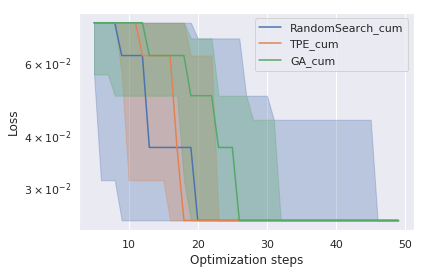

liblinear
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
liblinear
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
liblinear
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)


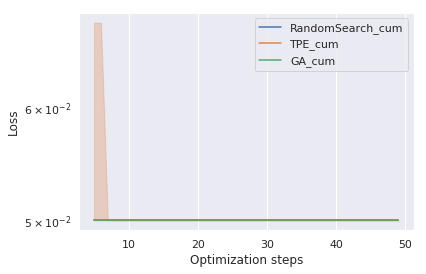

random_forest
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
random_forest
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)
random_forest
(10, 10, 50)
avg/std min_losses shape:  (45,) (45,)


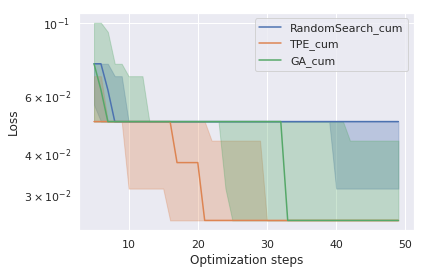

In [14]:
def plot_results(np_results, dataset_idx=0, avg_datasets=False, t_0=0, plot_ranges=True, use_log_scale=False):
    """
    Plot results for given dataset or averaged from given start t_0
    :param np_results: data to plot
    :param dataset_idx: index of dataset to plot, not needed if avg_datasets=True
    :param avg_datasets: Bool indicating whether to average over datasets or not
    :param t_0: first time step to plot from
    """
    for classifier in np_results[list(np_results.keys())[0]]:
        plt.figure()
        ax = plt.gca()
        for optimizer in np_results:
            color = next(ax._get_lines.prop_cycler)['color']
            print(classifier)
            print(np_results[optimizer][classifier].shape)
            tmp_data = np_results[optimizer][classifier] if avg_datasets else \
                np_results[optimizer][classifier][dataset_idx]
            
            avg_min_losses, std_min_losses, lower_min_losses, upper_min_losses = \
                get_mean_std_min_losses_per_timestep(tmp_data, avg_datasets=avg_datasets, t_0=t_0)
            plt.plot(range(t_0, t_0 + len(lower_min_losses)), avg_min_losses, label=optimizer + "_cum", color=color)
            if plot_ranges:
                plt.fill_between(x=range(t_0, t_0 + len(lower_min_losses)), y1=lower_min_losses,
                                 y2=upper_min_losses, alpha=0.3, color=color)
            
        plt.xlabel("Optimization steps")
        plt.ylabel("Loss")
        if use_log_scale:
            plt.yscale('log')
        plt.legend(loc='upper right')
        plt.show()
        
plot_results(loss_per_time_step, dataset_idx=1 , t_0=5)

libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
libsvm_svc
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)


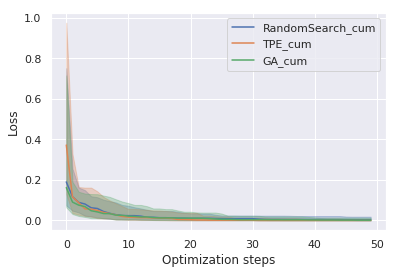

liblinear
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
liblinear
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
liblinear
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)


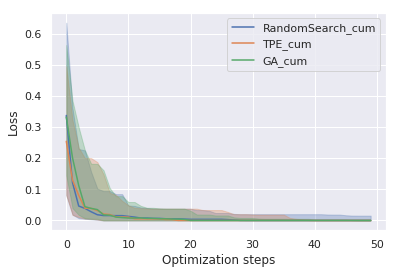

random_forest
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
random_forest
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)
random_forest
(10, 10, 50)
avg/std min_losses shape:  (50,) (50,)


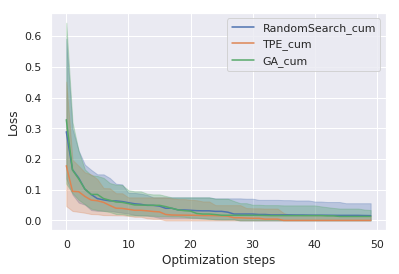

In [13]:
# Plot min max normalized losses
plot_results(min_max_normalized_loss_per_time_step, avg_datasets=True, t_0=0)

In [49]:
### Combined results
def combined_results_to_numpy(combined_optimizer_results, result_idx=1):
    """
    Convert combined classifiers experiment results to numpy array
    :param combined_optimizer_results: dict to convert to numpy with optimizers as keys
    :param result_idx: result idx: 
    0 = tmp_opt.hyperparameter_set_per_timestep, 
    1 = tmp_opt.eval_fn_per_timestep,
    2 = tmp_opt.cpu_time_per_opt_timestep, 
    3 = tmp_opt.wall_time_per_opt_timestep
    :return: dict with optimizers as keys containing numpy arrays of [dataset_idx, rep_idx, timestep]
    """
    np_results = {}
    for optimizer in combined_optimizer_results:
        print(optimizer)
        opt_results = combined_optimizer_results[optimizer]
        results = np.array(opt_results)
        results = np.array(results[:, :, :, result_idx], dtype=np.float32)
        print(results.shape)
        np_results[optimizer] = -results
    return np_results
        
combined_loss_per_time_step = combined_results_to_numpy(combined_optimizer_results)
combined_min_max_normalized_loss_per_time_step = {}
for o in list(combined_loss_per_time_step.keys()):
    tmp_loss = combined_loss_per_time_step[o]
    print(np.array([loss_ranges[c][:, 0], loss_ranges[c][:, 0], loss_ranges[c][:, 0], loss_ranges[c][:, 0]]).shape)
    min_losses = [loss_ranges[c][:, 0] for c in loss_ranges.keys()]
    min_loss = np.min(min_losses, axis=0)[:, None, None]#loss_ranges[c][:, 0][:, None, None]
    max_losses = [loss_ranges[c][:, 1] for c in loss_ranges.keys()]
    max_loss = np.max(max_losses, axis=0)[:, None, None]#loss_ranges[c][:, 1][:, None, None]
    combined_min_max_normalized_loss_per_time_step[o] = (tmp_loss - min_loss) / (max_loss - min_loss)

RandomSearch
(10, 10, 50)
TPE
(10, 10, 50)
GA
(10, 10, 50)
(4, 10)
(4, 10)
(4, 10)


(10, 10, 50)
avg/std min_losses shape:  (40,) (40,)
(10, 10, 50)
avg/std min_losses shape:  (40,) (40,)
(10, 10, 50)
avg/std min_losses shape:  (40,) (40,)


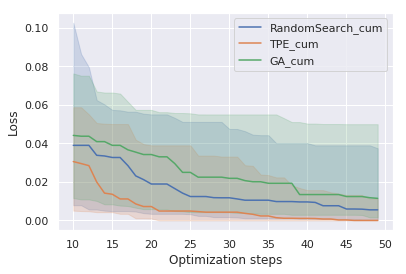

In [50]:
def new_plot_combined_results(np_results, dataset_idx=0, avg_datasets=False,t_0=0):
    plt.figure()
    ax = plt.gca()
    for optimizer in np_results:
        color = next(ax._get_lines.prop_cycler)['color']
        print(np_results[optimizer].shape)
        avg_min_losses, std_min_losses, lower_min_losses, upper_min_losses = get_mean_std_min_losses_per_timestep(np_results[optimizer], avg_datasets=avg_datasets, t_0=t_0)
        
        plt.plot(range(t_0, t_0 + len(lower_min_losses)), avg_min_losses, label=optimizer + "_cum", c=color)
        plt.fill_between(x=range(t_0, t_0 + len(lower_min_losses)), y1=lower_min_losses,
                         y2=upper_min_losses, alpha=0.2, color=color)
    plt.xlabel("Optimization steps")
    plt.ylabel("Loss")
    #plt.yscale('log')
    plt.legend(loc='upper right')
    plt.show()

new_plot_combined_results(combined_min_max_normalized_loss_per_time_step, avg_datasets=True, t_0=10)